## Titanic 沉没

这是一个分类任务，特征包含离散特征和连续特征，数据如下：[Kaggle地址](https://www.kaggle.com/c/titanic/data)。目标是根据数据特征预测一个人是否能在泰坦尼克的沉没事故中存活下来。接下来解释下数据的格式：

```
survival        目标列，是否存活，1代表存活 (0 = No; 1 = Yes)  
pclass          乘坐的舱位级别 (1 = 1st; 2 = 2nd; 3 = 3rd)  
name            姓名 
sex             性别  
age             年龄  
sibsp           兄弟姐妹的数量（乘客中）  
parch           父母的数量（乘客中）  
ticket          票号  
fare            票价  
cabin           客舱  
embarked        登船的港口  
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```

## 载入数据并分析

In [1]:
# -*- coding: UTF-8 -*-
%matplotlib inline

import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(big_string, substring) != -1:
            return substring
    return np.nan

def replace_titles(x):
    title=x['Title']
    if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Countess', 'Mme','Mrs']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms','Miss']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    elif title =='':
        if x['Sex']=='Male':
            return 'Master'
        else:
            return 'Miss'
    else:
        return title

title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']

In [3]:
label = train['Survived'] # 目标列

### Pclass、Sex、Embarked离散特征数据预览
除此之外Name、Ticket、Cabin也是离散特征，我们暂时不用这几个特征，直观上来讲，叫什么名字跟在事故中是否存活好像没有太大的联系。

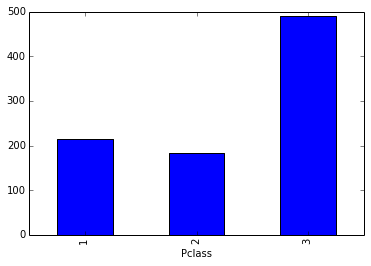

In [4]:
# 接下来我们对每个特征进行一下分析：
train.groupby(['Pclass'])['PassengerId'].count().plot(kind='bar')

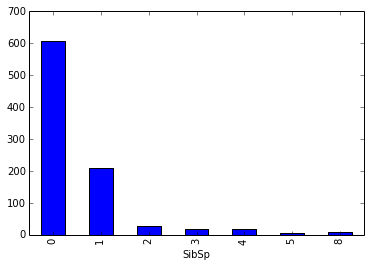

In [5]:
train.groupby(['SibSp'])['PassengerId'].count().plot(kind='bar')

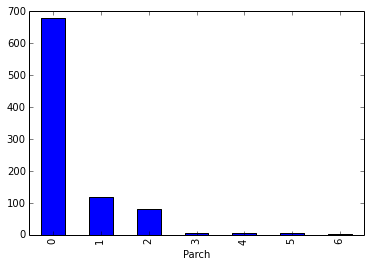

In [6]:
train.groupby(['Parch'])['PassengerId'].count().plot(kind='bar')

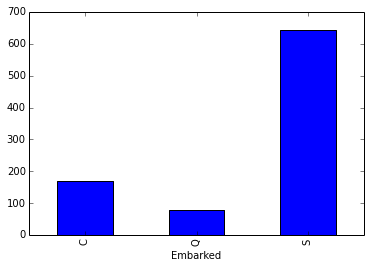

In [7]:
train.groupby(['Embarked'])['PassengerId'].count().plot(kind='bar')

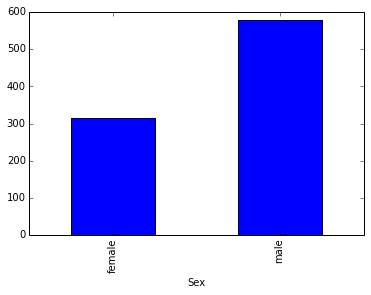

In [8]:
train.groupby(['Sex'])['PassengerId'].count().plot(kind='bar')

### 连续特征处理
Age、Fare是连续特征，观察数据分布查看是否有缺失值和异常值，我们看到Age中存在缺失值，我们考虑使用均值来填充缺失值。

In [9]:
print '检测是否有缺失值：'
print train[train['Age'].isnull()]['Age'].head()
print train[train['Fare'].isnull()]['Fare'].head()
print train[train['SibSp'].isnull()]['SibSp'].head()
print train[train['Parch'].isnull()]['Parch'].head()
train['Age'] = train['Age'].fillna(train['Age'].mean())
print '填充之后再检测：'
print train[train['Age'].isnull()]['Age'].head()
print train[train['Fare'].isnull()]['Fare'].head()

检测是否有缺失值：
5    NaN
17   NaN
19   NaN
26   NaN
28   NaN
Name: Age, dtype: float64
Series([], Name: Fare, dtype: float64)
Series([], Name: SibSp, dtype: int64)
Series([], Name: Parch, dtype: int64)
填充之后再检测：
Series([], Name: Age, dtype: float64)
Series([], Name: Fare, dtype: float64)


In [10]:
print '检测测试集是否有缺失值：'
print test[test['Age'].isnull()]['Age'].head()
print test[test['Fare'].isnull()]['Fare'].head()
print test[test['SibSp'].isnull()]['SibSp'].head()
print test[test['Parch'].isnull()]['Parch'].head()
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
print '填充之后再检测：'
print test[test['Age'].isnull()]['Age'].head()
print test[test['Fare'].isnull()]['Fare'].head()

检测测试集是否有缺失值：
10   NaN
22   NaN
29   NaN
33   NaN
36   NaN
Name: Age, dtype: float64
152   NaN
Name: Fare, dtype: float64
Series([], Name: SibSp, dtype: int64)
Series([], Name: Parch, dtype: int64)
填充之后再检测：
Series([], Name: Age, dtype: float64)
Series([], Name: Fare, dtype: float64)


In [11]:
# 处理Title特征
train['Title'] = train['Name'].map(lambda x: substrings_in_string(x, title_list))
test['Title'] = test['Name'].map(lambda x: substrings_in_string(x, title_list))

train['Title'] = train.apply(replace_titles, axis=1)
test['Title'] = test.apply(replace_titles, axis=1)

# family特征
train['Family_Size'] = train['SibSp'] + train['Parch']
train['Family'] = train['SibSp'] * train['Parch']
test['Family_Size'] = test['SibSp'] + test['Parch']
test['Family'] = test['SibSp'] * test['Parch']

In [12]:
train['AgeFill'] = train['Age']
mean_ages = np.zeros(4)
mean_ages[0] = np.average(train[train['Title'] == 'Miss']['Age'].dropna())
mean_ages[1] = np.average(train[train['Title'] == 'Mrs']['Age'].dropna())
mean_ages[2] = np.average(train[train['Title'] == 'Mr']['Age'].dropna())
mean_ages[3] = np.average(train[train['Title'] == 'Master']['Age'].dropna())
train.loc[ (train.Age.isnull()) & (train.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
train.loc[ (train.Age.isnull()) & (train.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
train.loc[ (train.Age.isnull()) & (train.Title == 'Master') ,'AgeFill'] = mean_ages[3]

train['AgeCat'] = train['AgeFill']
train.loc[ (train.AgeFill<=10), 'AgeCat'] = 'child'
train.loc[ (train.AgeFill>60), 'AgeCat'] = 'aged'
train.loc[ (train.AgeFill>10) & (train.AgeFill <=30) ,'AgeCat'] = 'adult'
train.loc[ (train.AgeFill>30) & (train.AgeFill <=60) ,'AgeCat'] = 'senior'

train['Fare_Per_Person'] = train['Fare'] / (train['Family_Size'] + 1)

In [13]:
test['AgeFill'] = test['Age']
mean_ages = np.zeros(4)
mean_ages[0] = np.average(test[test['Title'] == 'Miss']['Age'].dropna())
mean_ages[1] = np.average(test[test['Title'] == 'Mrs']['Age'].dropna())
mean_ages[2] = np.average(test[test['Title'] == 'Mr']['Age'].dropna())
mean_ages[3] = np.average(test[test['Title'] == 'Master']['Age'].dropna())
test.loc[ (test.Age.isnull()) & (test.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
test.loc[ (test.Age.isnull()) & (test.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
test.loc[ (test.Age.isnull()) & (test.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
test.loc[ (test.Age.isnull()) & (test.Title == 'Master') ,'AgeFill'] = mean_ages[3]

test['AgeCat'] = test['AgeFill']
test.loc[ (test.AgeFill<=10), 'AgeCat'] = 'child'
test.loc[ (test.AgeFill>60), 'AgeCat'] = 'aged'
test.loc[ (test.AgeFill>10) & (test.AgeFill <=30) ,'AgeCat'] = 'adult'
test.loc[ (test.AgeFill>30) & (test.AgeFill <=60) ,'AgeCat'] = 'senior'

test['Fare_Per_Person'] = test['Fare'] / (test['Family_Size'] + 1)

In [14]:
train.Embarked = train.Embarked.fillna('S')
test.Embarked = test.Embarked.fillna('S')

train.loc[ train.Cabin.isnull() == True, 'Cabin'] = 0.2
train.loc[ train.Cabin.isnull() == False, 'Cabin'] = 1

test.loc[ test.Cabin.isnull() == True, 'Cabin'] = 0.2
test.loc[ test.Cabin.isnull() == False, 'Cabin'] = 1

In [15]:
#Age times class
train['AgeClass'] = train['AgeFill'] * train['Pclass']
train['ClassFare'] = train['Pclass'] * train['Fare_Per_Person']

train['HighLow'] = train['Pclass']
train.loc[ (train.Fare_Per_Person < 8) ,'HighLow'] = 'Low'
train.loc[ (train.Fare_Per_Person >= 8) ,'HighLow'] = 'High'

#Age times class
test['AgeClass'] = test['AgeFill'] * test['Pclass']
test['ClassFare'] = test['Pclass'] * test['Fare_Per_Person']

test['HighLow'] = test['Pclass']
test.loc[ (test.Fare_Per_Person < 8) ,'HighLow'] = 'Low'
test.loc[ (test.Fare_Per_Person >= 8) ,'HighLow'] = 'High'

In [16]:
print train.head(1)
# print test.head()

   PassengerId  Survived  Pclass                     Name   Sex   Age  SibSp  \
0            1         0       3  Braund, Mr. Owen Harris  male  22.0      1   

   Parch     Ticket  Fare   ...    Embarked Title Family_Size  Family  \
0      0  A/5 21171  7.25   ...           S    Mr           1       0   

   AgeFill  AgeCat Fare_Per_Person  AgeClass  ClassFare  HighLow  
0     22.0   adult           3.625      66.0     10.875      Low  

[1 rows x 21 columns]


## 特征工程

In [17]:
# 处理训练集
Pclass = pd.get_dummies(train.Pclass)
Sex = pd.get_dummies(train.Sex)
Embarked = pd.get_dummies(train.Embarked)
Title = pd.get_dummies(train.Title)
AgeCat = pd.get_dummies(train.AgeCat)
HighLow = pd.get_dummies(train.HighLow)
train_data = pd.concat([Pclass, Sex, Embarked, Title, AgeCat, HighLow], axis=1)
train_data['Age'] = train['Age']
train_data['Fare'] = train['Fare']
train_data['SibSp'] = train['SibSp']
train_data['Parch'] = train['Parch']
train_data['Family_Size'] = train['Family_Size']
train_data['Family'] = train['Family']
train_data['AgeFill'] = train['AgeFill']
train_data['Fare_Per_Person'] = train['Fare_Per_Person']
train_data['Cabin'] = train['Cabin']
train_data['AgeClass'] = train['AgeClass']
train_data['ClassFare'] = train['ClassFare']

cols = ['Age', 'Fare', 'SibSp', 'Parch', 'Family_Size', 'Family', 'AgeFill', 'Fare_Per_Person', 'AgeClass', 'ClassFare']
train_data[cols] = train_data[cols].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
print train_data.head()

# 处理测试集
Pclass = pd.get_dummies(test.Pclass)
Sex = pd.get_dummies(test.Sex)
Embarked = pd.get_dummies(test.Embarked)
Title = pd.get_dummies(test.Title)
AgeCat = pd.get_dummies(test.AgeCat)
HighLow = pd.get_dummies(test.HighLow)
test_data = pd.concat([Pclass, Sex, Embarked, Title, AgeCat, HighLow], axis=1)
test_data['Age'] = test['Age']
test_data['Fare'] = test['Fare']
test_data['SibSp'] = test['SibSp']
test_data['Parch'] = test['Parch']
test_data['Family_Size'] = test['Family_Size']
test_data['Family'] = test['Family']
test_data['AgeFill'] = test['AgeFill']
test_data['Fare_Per_Person'] = test['Fare_Per_Person']
test_data['Cabin'] = test['Cabin']
test_data['AgeClass'] = test['AgeClass']
test_data['ClassFare'] = test['ClassFare']

test_data[cols] = test_data[cols].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
print test_data.head()

     1    2    3  female  male    C    Q    S  Master  Miss    ...      \
0  0.0  0.0  1.0     0.0   1.0  0.0  0.0  1.0     0.0   0.0    ...       
1  1.0  0.0  0.0     1.0   0.0  1.0  0.0  0.0     0.0   0.0    ...       
2  0.0  0.0  1.0     1.0   0.0  0.0  0.0  1.0     0.0   1.0    ...       
3  1.0  0.0  0.0     1.0   0.0  0.0  0.0  1.0     0.0   0.0    ...       
4  0.0  0.0  1.0     0.0   1.0  0.0  0.0  1.0     0.0   0.0    ...       

       Fare     SibSp     Parch  Family_Size    Family   AgeFill  \
0 -0.048707  0.059624 -0.063599      0.00954 -0.035494 -0.096747   
1  0.076277  0.059624 -0.063599      0.00954 -0.035494  0.104309   
2 -0.047390 -0.065376 -0.063599     -0.09046 -0.035494 -0.046483   
3  0.040786  0.059624 -0.063599      0.00954 -0.035494  0.066611   
4 -0.047146 -0.065376 -0.063599     -0.09046 -0.035494  0.066611   

   Fare_Per_Person  Cabin  AgeClass  ClassFare  
0        -0.031799      1  0.004673  -0.040180  
1         0.030694      1 -0.121978   0.008161  

## 模型训练

In [18]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import RandomForestClassifier

import numpy as np

### 逻辑回归

In [19]:
model_lr = LR(penalty = 'l2', dual = True, random_state = 0)
model_lr.fit(train_data, label)
print "逻辑回归10折交叉验证得分: ", np.mean(cross_val_score(model_lr, train_data, label, cv=10, scoring='roc_auc'))

result = model_lr.predict( test_data )
output = pd.DataFrame( data={"PassengerId":test["PassengerId"], "Survived":result} )
output.to_csv( "lr.csv", index=False, quoting=3 )

逻辑回归10折交叉验证得分:  0.871878335172


#### 提交kaggle后准确率：0.78469

### 高斯贝叶斯

In [20]:
model_GNB = GNB()
model_GNB.fit(train_data, label)
print "高斯贝叶斯分类器10折交叉验证得分: ", np.mean(cross_val_score(model_GNB, train_data, label, cv=10, scoring='roc_auc'))

result = model_GNB.predict( test_data )
output = pd.DataFrame( data={"PassengerId":test["PassengerId"], "Survived":result} )
output.to_csv( "gnb.csv", index=False, quoting=3 )

高斯贝叶斯分类器10折交叉验证得分:  0.857323798206


#### 提交kaggle后准确率：0.74163

### 随机森林

In [21]:
forest = RandomForestClassifier( n_estimators=500, criterion='entropy', max_depth=5, min_samples_split=1,
  min_samples_leaf=1, max_features='auto', bootstrap=False, oob_score=False, n_jobs=4,
  verbose=0)

%time forest = forest.fit( train_data, label )
print "随机森林分类器10折交叉验证得分: ", np.mean(cross_val_score(forest, train_data, label, cv=10, scoring='roc_auc'))

result = forest.predict( test_data )
output = pd.DataFrame( data={"PassengerId":test["PassengerId"], "Survived":result} )
output.to_csv( "rf.csv", index=False, quoting=3 )

CPU times: user 1.34 s, sys: 208 ms, total: 1.55 s
Wall time: 1.17 s
随机森林分类器10折交叉验证得分:  0.870820473644


#### 提交kaggle后准确率：0.76555

--------

## 寻找最佳参数

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold
param_grid = dict( )

pipeline=Pipeline([ ('clf', forest) ])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=3, scoring='accuracy',
cv=StratifiedShuffleSplit(label, n_iter=10, test_size=0.2, train_size=None)).fit(train_data, label)

print("Best score: %0.3f" % grid_search.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ....................................... , score=0.849162 -   1.7s
[CV]  ................................................................
[CV] ....................................... , score=0.843575 -   1.5s
[CV]  ................................................................
[CV] ....................................... , score=0.804469 -   1.4s
[CV]  ................................................................
[CV] ....................................... , score=0.804469 -   1.9s
[CV]  ................................................................
[CV] ....................................... , score=0.871508 -   2.1s
[CV]  ................................................................
[CV] ....................................... , score=0.865922 -   1.9s
[CV]  ................................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Best score: 0.842
